In [1]:
from keras.layers import Conv2D,Conv2DTranspose,MaxPooling2D,Dropout,Concatenate,Input
from keras import Model
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import pandas as pd

from keras.utils import plot_model
from matplotlib.pyplot import figure

2024-04-03 11:57:55.001382: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-03 11:57:55.001425: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-03 11:57:55.025883: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-03 11:57:55.079219: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-03 11:57:55.711144: W tensorflow/compiler/tf2

In [2]:
def double_conv_block(prev_layer, filter_count):
   new_layer = Conv2D(filter_count, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(prev_layer)
   new_layer = Conv2D(filter_count, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(new_layer)
   return new_layer

def downsample_block(prev_layer, filter_count):
   skip_features = double_conv_block(prev_layer, filter_count)
   down_sampled = MaxPooling2D(2)(skip_features)
   down_sampled = Dropout(0.3)(down_sampled)
   return skip_features, down_sampled

def upsample_block(prev_layer, skipped_features, n_filters):
   upsampled = Conv2DTranspose(n_filters, 3, 2, padding="same")(prev_layer)
   upsampled = Concatenate()([upsampled, skipped_features])
   upsampled = Dropout(0.3)(upsampled)
   upsampled = double_conv_block(upsampled, n_filters)
   return upsampled

In [3]:
def make_unet():
   inputs = Input(shape=(128,128,1))


   skipped_fmaps_1, downsample_1 = downsample_block(inputs, 64)
   skipped_fmaps_2, downsample_2 = downsample_block(downsample_1, 128)
   skipped_fmaps_3, downsample_3 = downsample_block(downsample_2, 256)
   skipped_fmaps_4, downsample_4 = downsample_block(downsample_3, 512)

   bottleneck = double_conv_block(downsample_4, 1024)
   
   upsample_1 = upsample_block(bottleneck, skipped_fmaps_4, 512)
   upsample_2 = upsample_block(upsample_1, skipped_fmaps_3, 256)
   upsample_3 = upsample_block(upsample_2, skipped_fmaps_2, 128)
   upsample_4 = upsample_block(upsample_3, skipped_fmaps_1, 64)


   outputs = Conv2D(1, 1, padding="same", activation = "sigmoid")(upsample_4)

   unet_model = Model(inputs, outputs, name="U-Net")

   return unet_model

In [4]:
u_net = make_unet()
u_net.summary()

2024-04-03 11:58:00.040307: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-03 11:58:00.153812: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-03 11:58:00.153843: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-03 11:58:00.156635: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-03 11:58:00.156668: I external/local_xla/xla/stream_executor

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         640       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-03 11:58:00.339824: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-03 11:58:00.339861: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-03 11:58:00.339866: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2022] Could not identify NUMA node of platform GPU id 0, defaulting to 0.  Your kernel may not have been built with NUMA support.
2024-04-03 11:58:00.339886: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000

                                                                                                  
 conv2d_11 (Conv2D)          (None, 16, 16, 512)          2359808   ['conv2d_10[0][0]']           
                                                                                                  
 conv2d_transpose_1 (Conv2D  (None, 32, 32, 256)          1179904   ['conv2d_11[0][0]']           
 Transpose)                                                                                       
                                                                                                  
 concatenate_1 (Concatenate  (None, 32, 32, 512)          0         ['conv2d_transpose_1[0][0]',  
 )                                                                   'conv2d_5[0][0]']            
                                                                                                  
 dropout_5 (Dropout)         (None, 32, 32, 512)          0         ['concatenate_1[0][0]']       
          

In [5]:
images = os.listdir("./ChestXray/train/image")
masks = os.listdir("./ChestXray/train/mask")
v_images = os.listdir("./ChestXray/val/image")
v_masks = os.listdir("./ChestXray/val/mask")

In [6]:
print(len(images)==len(masks))
print(len(v_images)==len(v_masks))

True
True


In [7]:
masks.sort()
images.sort()
v_masks.sort()
v_images.sort()

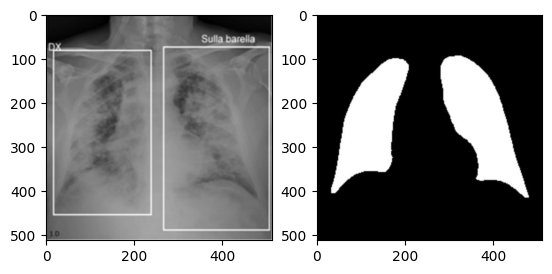

In [8]:
img = np.asanyarray(Image.open(os.path.join("./ChestXray/train/image",images[1])))
mask = Image.open(os.path.join("./ChestXray/train/mask",masks[1]))

plt.subplot(1,2,1)
plt.imshow(img[:,:,:3]) #rgba to rgb
plt.subplot(1,2,2)
plt.imshow(mask)
plt.show()

In [9]:
def make_dataset(validation=False):
  x = []
  y = []
  if(validation):
    for i,(image,mask) in enumerate(zip(v_images[:10000],v_masks[:10000])):
      print("\r"+str(i)+"/"+str(len(v_images)),end="")

      image = Image.open(os.path.join("./ChestXray/val/image",image)).convert('L')
      mask = Image.open(os.path.join("./ChestXray/val/mask",mask)).convert('L')

      image = np.asarray(image.resize((128,128)))/255.
      mask = np.asarray(mask.resize((128,128)))/255.

      x.append(image)
      y.append(mask)
  else:
    for i,(image,mask) in enumerate(zip(images[:10000],masks[:10000])):
      print("\r"+str(i)+"/"+str(len(images)),end="")
      
      image = Image.open(os.path.join("./ChestXray/train/image",image)).convert('L')
      mask = Image.open(os.path.join("./ChestXray/train/mask",mask)).convert('L')

      image = np.asarray(image.resize((128,128)))/255.
      mask = np.asarray(mask.resize((128,128)))/255.

      x.append(image)
      y.append(mask)

  return np.array(x),np.array(y)

In [10]:
x,y = make_dataset()

9999/16932

In [11]:
v_x,v_y = make_dataset(True)

2116/2117

In [12]:
x,y = np.expand_dims(x,axis=-1),np.expand_dims(y,axis=-1)
v_x,v_y = np.expand_dims(v_x,axis=-1),np.expand_dims(v_y,axis=-1)

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen_args = dict(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode="nearest",
    horizontal_flip=True,
    vertical_flip=True,
)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

seed = 1

image_generator = image_datagen.flow(
    x,
    batch_size=64,
    seed=seed)

mask_generator = mask_datagen.flow(
    y,
    batch_size=64,
    seed=seed)

train_generator = zip(image_generator, mask_generator)

In [14]:
image_test_datagen = ImageDataGenerator()
mask_test_datagen = ImageDataGenerator()

seed = 1

image_test_generator = image_test_datagen.flow(
    v_x,
    batch_size=64,
    seed=seed)

mask_test_generator = mask_test_datagen.flow(
    v_y,
    batch_size=64,
    seed=seed)

valid_generator = zip(image_test_generator, mask_test_generator)

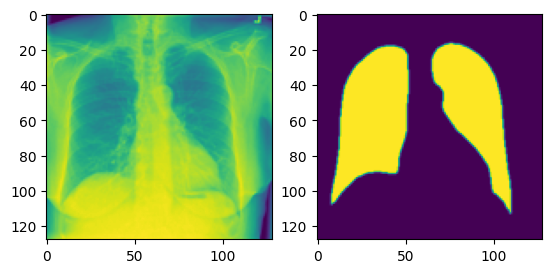

In [16]:
import random
i = random.randint(0,len(x))

img = x[i]
mask = y[i]

plt.subplot(1,2,1)
plt.imshow(np.squeeze(img))

plt.subplot(1,2,2)
plt.imshow(np.squeeze(mask))

plt.show()

In [17]:
u_net.compile(optimizer="adam",loss="binary_crossentropy",metrics="accuracy")

In [18]:
model_history = u_net.fit(train_generator,epochs=20,validation_data=valid_generator,steps_per_epoch = int(x.shape[0] / 64),validation_steps = int(v_x.shape[0] / 64))

Epoch 1/20


2024-04-03 12:02:38.407492: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inU-Net/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-04-03 12:02:38.604712: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-04-03 12:02:38.832077: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-03 12:02:39.229058: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-03 12:02:41.233731: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f9d6198ecc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-03 12:02:41.233755: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, C

156/156 [==============================] - 42s 177ms/step - loss: 0.3490 - accuracy: 0.7954 - val_loss: 0.2271 - val_accuracy: 0.8809
Epoch 2/20
156/156 [==============================] - 32s 183ms/step - loss: 0.1244 - accuracy: 0.8923 - val_loss: 0.0945 - val_accuracy: 0.9286
Epoch 3/20
156/156 [==============================] - 26s 168ms/step - loss: 0.0781 - accuracy: 0.9047 - val_loss: 0.0864 - val_accuracy: 0.9311
Epoch 4/20
156/156 [==============================] - 24s 152ms/step - loss: 0.0637 - accuracy: 0.9085 - val_loss: 0.0807 - val_accuracy: 0.9322
Epoch 5/20
156/156 [==============================] - 24s 152ms/step - loss: 0.0570 - accuracy: 0.9098 - val_loss: 0.0638 - val_accuracy: 0.9375
Epoch 6/20
156/156 [==============================] - 24s 152ms/step - loss: 0.0524 - accuracy: 0.9108 - val_loss: 0.0677 - val_accuracy: 0.9358
Epoch 7/20
156/156 [==============================] - 24s 152ms/step - loss: 0.0508 - accuracy: 0.9112 - val_loss: 0.0714 - val_accuracy: 0.9

In [19]:
u_net.save("u_net.h5")

/home/xpert/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 1s 547ms/step


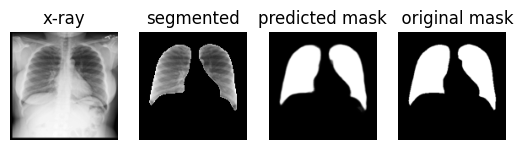

In [20]:
i = random.randint(0,len(v_x)-1)

original = v_x[i].copy()
original_mask = v_y[i].copy()

mask = u_net.predict(np.expand_dims(original,axis=0))


segmented = np.squeeze(original).copy()
segmented[np.squeeze(mask)<0.2] = 0